# Classification RFM model on app sales dataset

RFM which stands for **Recency Frequency Monetary Value** is a common approach towards analyzing sales data. In this excercise I'll go through applying this methodology in real app sales data example.

In [46]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import math

url = "https://raw.githubusercontent.com/slawomirwojtas/ML-Projects/main/app_sales_data.csv"

df = pd.read_csv(url)
df.head()

,Transaction ID,Transaction Created At,User ID,Class ID,Transaction Value
0,1ed576b6-cf17-66b0-b309-b9bcbe1c29ed,2022-10-29 09:24:00,1ed466a4-fe54-62d4-805a-8f8ec1f6ea58,1ed174ab-f954-6448-b9cf-63ddad9ec067,107.95
1,1ed57a94-0202-6d8c-b91e-e1a395a08b60,2022-10-29 16:46:00,1ed57910-481b-6ec0-a20c-efc2de556cd7,1ed174ab-f954-6448-b9cf-63ddad9ec067,13.60
2,1ed57abf-0ba7-624a-aa0c-21196985d3c3,2022-10-29 17:05:00,1ed56efc-e7f5-6fe0-be39-f3bafa80f38b,1ed174ab-f954-6448-b9cf-63ddad9ec067,18.70
3,1ed57ac5-1da5-6cca-9402-05b0faf820bb,2022-10-29 17:08:00,1ed57ab7-f018-626a-9e2d-5f63b043a4c1,1ed174ab-f954-6448-b9cf-63ddad9ec067,22.10
4,1ed57adb-e764-6c76-8b2a-abef80baea6e,2022-10-29 17:18:00,1ed577d3-16dc-691a-8b9b-fb2aa265988a,1ed174ab-f954-6448-b9cf-63ddad9ec067,27.20


# Data pre-processing & feature engineering

The dataset consists transactions of different users. I will skip EDA and focus on applying the methodology. Basically I want to identify churn by observing the first 90 days of users' live from their first transaction. Then if they make another transaction within the next 90 days they are no-churn. Now I'll create a users dictionary that will be later filled with transaction data.

In [21]:
# Create column consisting transaction date without hours-minutes
df["Transaction Day"] = df["Transaction Created At"].astype("str").str[:10]
df["Transaction Day"] = pd.to_datetime(df["Transaction Day"])

df_user_dict = df.copy()
df_user_dict.sort_values(by=['User ID', 'Transaction Created At'], ascending=True, inplace=True)
df_user_dict.drop_duplicates(subset=['User ID'], keep='first', inplace=True)
df_user_dict.reset_index(drop=True, inplace=True)
df_user_dict = df_user_dict[['User ID', 'Class ID', 'Transaction Day']]
df_user_dict.rename(columns={'Class ID': 'Conversion Class ID',
                             'Transaction Day': '1st Transaction'}, inplace=True)
df_user_dict['Trial Window End'] = df_user_dict['1st Transaction'] + timedelta(days=90)
df_user_dict['Churn Window End'] = df_user_dict['1st Transaction'] + timedelta(days=180)
df_user_dict.head()

,User ID,Conversion Class ID,1st Transaction,Trial Window End,Churn Window End
0,1ed43f3e-c335-642e-b1f2-eb325b0afde1,1ed56bd3-8967-6716-a401-4318106f6f5e,2022-11-26,2023-02-24,2023-05-25
1,1ed448da-290e-61c0-aefe-e9a8fe371c81,1ed4bd1b-1645-697a-92e0-33af0ced97f8,2023-01-01,2023-04-01,2023-06-30
2,1ed44f7d-7f35-6130-8556-dbc322ff8df1,1ed56d5f-a200-692a-af71-ef4bb4b35809,2022-10-29,2023-01-27,2023-04-27
3,1ed466a4-fe54-62d4-805a-8f8ec1f6ea58,1ed174ab-f954-6448-b9cf-63ddad9ec067,2022-10-29,2023-01-27,2023-04-27
4,1ed55f32-99d1-6bd6-83b4-dfd0f42b54e7,1ed4bd1b-1645-697a-92e0-33af0ced97f8,2023-02-16,2023-05-17,2023-08-15


In [22]:
# Exclude results with churn window outside data date range
max_date_avalilable = df['Transaction Day'].max()
df_user_dict = df_user_dict[df_user_dict['Churn Window End'] <= max_date_avalilable]

Now it's time to collect the information about transaction recency, frequency and monetary value. Also about whether the users churned or not.

* Transaction Count will be how many transactions they made within the first 90 days (frequency)
* Transaction Spread will be how many days passed between the first and the last transaction in the 90 days window (recency)
* Transaction Value is how much money they spent in the trial period

In [23]:
# Create feature columns
df_user_dict['Transaction Count'] = np.nan
df_user_dict['Transaction Spread'] = np.nan
df_user_dict['Transaction Value'] = np.nan
df_user_dict['Churn'] = np.nan


# Iterate through rows and calculate metrics
for index, row in df_user_dict.iterrows():

    user_id = df_user_dict['User ID'][index]
    first_transaction = df_user_dict['1st Transaction'][index]
    trial_window = df_user_dict['Trial Window End'][index]
    churn_window = df_user_dict['Churn Window End'][index]

    temp_df = df[df['User ID'] == user_id].copy()

    # Calculate metrics
    transaction_count = temp_df[temp_df['Transaction Day'] <= trial_window].shape[0]
    df_user_dict.loc[index, 'Transaction Count'] = transaction_count

    transaction_spread = (temp_df[temp_df['Transaction Day'] <= trial_window]['Transaction Day'].max() - first_transaction).days
    df_user_dict.loc[index, 'Transaction Spread'] = transaction_spread

    transaction_value = temp_df[temp_df['Transaction Day'] <= trial_window]['Transaction Value'].sum()
    df_user_dict.loc[index, 'Transaction Value'] = transaction_value

    if temp_df[(temp_df['Transaction Day'] > trial_window) & (temp_df['Transaction Day'] <= churn_window)].shape[0] == 0:
        churn_flag = 1
    else:
        churn_flag = 0
    df_user_dict.loc[index, 'Churn'] = churn_flag

print(df_user_dict.shape)
df_user_dict.head()


,User ID,Conversion Class ID,1st Transaction,Trial Window End,Churn Window End,Transaction Count,Transaction Spread,Transaction Value,Churn
0,1ed43f3e-c335-642e-b1f2-eb325b0afde1,1ed56bd3-8967-6716-a401-4318106f6f5e,2022-11-26,2023-02-24,2023-05-25,1.0,0.0,59.20,0.0
1,1ed448da-290e-61c0-aefe-e9a8fe371c81,1ed4bd1b-1645-697a-92e0-33af0ced97f8,2023-01-01,2023-04-01,2023-06-30,2.0,50.0,54.00,0.0
2,1ed44f7d-7f35-6130-8556-dbc322ff8df1,1ed56d5f-a200-692a-af71-ef4bb4b35809,2022-10-29,2023-01-27,2023-04-27,29.0,90.0,2726.10,0.0
3,1ed466a4-fe54-62d4-805a-8f8ec1f6ea58,1ed174ab-f954-6448-b9cf-63ddad9ec067,2022-10-29,2023-01-27,2023-04-27,1.0,0.0,107.95,0.0
4,1ed55f32-99d1-6bd6-83b4-dfd0f42b54e7,1ed4bd1b-1645-697a-92e0-33af0ced97f8,2023-02-16,2023-05-17,2023-08-15,1.0,0.0,66.90,0.0


I know from the business perspective that some of the Class IDs should be invalidated. That's why I'm removing users who converted with them from the data sample.

In [27]:
invalid_class_ids = ['1ed174ab-f954-6448-b9cf-63ddad9ec067', '1edb80cb-f597-636a-bab1-cfcaabe89ac0', '1edca287-ba54-6468-86a9-770b937f85cb', '1edf3055-b668-6f6c-9689-c70ddba42f40']
df_user_dict['helper'] = [class_id in invalid_class_ids for class_id in df_user_dict['Conversion Class ID']]
df_user_dict = df_user_dict[df_user_dict['helper'] == False]
df_user_dict.drop(columns=['helper'], inplace=True)
df_user_dict.reset_index(drop=True, inplace=True)
print('Sample with valid conversion class_ids')
print(df_user_dict.shape)
df_user_dict.head()


Sample with valid conversion class_ids
(3308, 9)


,User ID,Conversion Class ID,1st Transaction,Trial Window End,Churn Window End,Transaction Count,Transaction Spread,Transaction Value,Churn
0,1ed43f3e-c335-642e-b1f2-eb325b0afde1,1ed56bd3-8967-6716-a401-4318106f6f5e,2022-11-26,2023-02-24,2023-05-25,1.0,0.0,59.2,0.0
1,1ed448da-290e-61c0-aefe-e9a8fe371c81,1ed4bd1b-1645-697a-92e0-33af0ced97f8,2023-01-01,2023-04-01,2023-06-30,2.0,50.0,54.0,0.0
2,1ed44f7d-7f35-6130-8556-dbc322ff8df1,1ed56d5f-a200-692a-af71-ef4bb4b35809,2022-10-29,2023-01-27,2023-04-27,29.0,90.0,2726.1,0.0
3,1ed55f32-99d1-6bd6-83b4-dfd0f42b54e7,1ed4bd1b-1645-697a-92e0-33af0ced97f8,2023-02-16,2023-05-17,2023-08-15,1.0,0.0,66.9,0.0
4,1ed55f7f-8d66-6980-9e7c-53d04c2efa5a,1ed4bd1b-1645-697a-92e0-33af0ced97f8,2023-03-02,2023-05-31,2023-08-29,1.0,0.0,24.0,1.0


# Balancing the sample

Because I don't want the model to be confused by sheer prevalence of churn in the data sample I need to balance the churn and non-churn occurences. I also want to make sure that the samples are shuffled so the are not in chronoligical order that might be affected by some seasonal trends.

In [28]:
# Check sample balance
print('Sample balance')
print(df_user_dict['Churn'].value_counts().to_frame())
samples_nochurn = df_user_dict['Churn'].value_counts().to_frame()['Churn'][0]
samples_churn = df_user_dict['Churn'].value_counts().to_frame()['Churn'][1]
print(f'samples with no churn: {samples_nochurn}')
print(f'samples with churn: {samples_churn}')

Sample balance
     Churn
1.0   2705
0.0    603
samples with no churn: 603
samples with churn: 2705


In [30]:
min_samples = min([samples_nochurn, samples_churn])
print(f'Min samples for balance: {min_samples}')

Min samples for balance: 603


In [31]:
# Create balanced samples
df_sample_churn = df_user_dict[df_user_dict['Churn'] == 1].copy()
df_sample_churn = df_sample_churn.sample(frac=1, random_state=42).reset_index(drop=True)
df_sample_churn = df_sample_churn.head(min_samples)

df_sample_nochurn = df_user_dict[df_user_dict['Churn'] == 0].copy()
df_sample_nochurn = df_sample_nochurn.sample(frac=1, random_state=42).reset_index(drop=True)
df_sample_nochurn = df_sample_nochurn.head(min_samples)

df_sample_balanced = pd.concat([df_sample_churn, df_sample_nochurn])
df_sample_balanced = df_sample_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
print('Balanced sample')
print(df_sample_balanced.shape)
df_sample_balanced.head()


Balanced sample
(1206, 9)


,User ID,Conversion Class ID,1st Transaction,Trial Window End,Churn Window End,Transaction Count,Transaction Spread,Transaction Value,Churn
0,1ee416f5-b844-6922-9849-8b204262cf59,1edff1f5-a1b8-66c8-86f2-d7057fad208c,2023-08-24,2023-11-22,2024-02-20,1.0,0.0,25.50,1.0
1,1ede1e84-91d7-6ccc-8eaf-f554fbfd23cd,1ed717bb-ad14-6b1a-9b60-ed3bbb5e4919,2023-05-28,2023-08-26,2023-11-24,3.0,34.0,131.20,1.0
2,1ede2d32-1019-6e76-a585-4d100a5529cc,1edd39ae-b7e4-6b38-80f1-4b16d6c0a45b,2023-05-16,2023-08-14,2023-11-12,3.0,42.0,121.40,0.0
3,1edfd9c5-8e69-6b64-a227-3ff990f765c9,1edd9ee3-e91e-64b6-88d9-39598f11ced8,2023-07-01,2023-09-29,2023-12-28,1.0,0.0,70.00,1.0
4,1ee06048-595a-684c-acec-39305efdb6a5,1edd9ee3-e91e-64b6-88d9-39598f11ced8,2023-08-11,2023-11-09,2024-02-07,4.0,64.0,453.85,0.0


# Model training and testing

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

X = df_sample_balanced[['Transaction Count', 'Transaction Spread', 'Transaction Value']]
y = df_sample_balanced['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check balance
print('Train balance')
print(y_train.value_counts())
print('Test balance')
print(y_test.value_counts())

Train balance
0.0    484
1.0    480
Name: Churn, dtype: int64
Test balance
1.0    123
0.0    119
Name: Churn, dtype: int64


In [34]:
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [35]:
# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.7396694214876033
Precision: 0.6923076923076923
Recall: 0.8780487804878049
F1 Score: 0.7741935483870966
ROC AUC Score: 0.7373437179749949
Confusion Matrix:
 [[ 71  48]
 [ 15 108]]


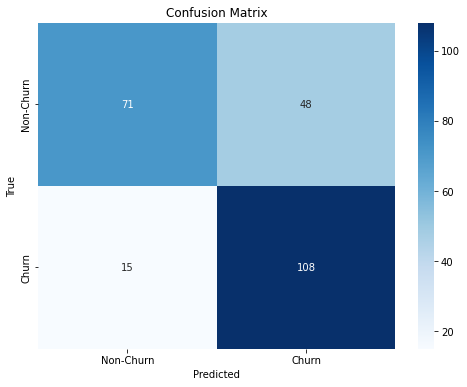

In [41]:
# Confusion matrix pretty print
class_labels = ['Non-Churn', 'Churn']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [44]:
# Put predictions back to the sample
test_indices = X_test.index
df_full_test_sample = df_sample_balanced.loc[test_indices, ['User ID', 'Conversion Class ID', '1st Transaction', 'Trial Window End', 'Churn Window End', 'Transaction Count', 'Transaction Spread', 'Transaction Value', 'Churn']]
df_full_test_sample['Churn Probability'] = model.predict_proba(X_test)[:, 1]
df_full_test_sample['Prediction'] = y_pred
print('Balanced test sample with predictions')
df_full_test_sample.head()

Balanced test sample with predictions


,User ID,Conversion Class ID,1st Transaction,Trial Window End,Churn Window End,Transaction Count,Transaction Spread,Transaction Value,Churn,Churn Probability,Prediction
101,1edfe439-8484-6b84-99e9-ed6e5ef8eca9,1edfba6f-ffa0-6e6a-b1bb-63c998c17875,2023-05-30,2023-08-28,2023-11-26,1.0,0.0,60.90,1.0,0.693823,1.0
260,1ed55f32-99d1-6bd6-83b4-dfd0f42b54e7,1ed4bd1b-1645-697a-92e0-33af0ced97f8,2023-02-16,2023-05-17,2023-08-15,1.0,0.0,66.90,0.0,0.693489,1.0
777,1edf6093-7c58-6624-b875-f32728301de5,1edd9ee3-e91e-64b6-88d9-39598f11ced8,2023-07-14,2023-10-12,2024-01-10,4.0,85.0,456.00,0.0,0.111940,0.0
109,1edfa7e1-cb0e-65f8-8519-351f0caa1183,1edd9ee3-e91e-64b6-88d9-39598f11ced8,2023-07-29,2023-10-27,2024-01-25,6.0,69.0,653.35,0.0,0.131037,0.0
649,1edbf3c5-ac0f-67b6-92b9-598cc72a9659,1ed4bd1b-1645-697a-92e0-33af0ced97f8,2023-03-24,2023-06-22,2023-09-20,2.0,57.0,131.40,0.0,0.278350,0.0


In [48]:
# Predict one sample
coefficients = model.coef_
intercept = model.intercept_

print("Feature coefficients:")
print(coefficients)
print("\nIntercept:")
print(intercept)

# Predict a single user
def predict_logistic_regression(features):
    result = intercept[0]
    for i in range(len(features)):
        result += coefficients[0][i] * features[i]
    probability = 1 / (1 + math.exp(-result))
    return probability

sample_features = [3, 70, 44]  # Transaction Count, Transaction Spread, Transaction Value
prediction = predict_logistic_regression(sample_features)
print("\nPredicted churn probability:", prediction)

Feature coefficients:
[[-0.11438604 -0.02873425 -0.00026211]]

Intercept:
[0.94840359]

Predicted churn probability: 0.19502477918560937


As we see from the coefficients transaction value impact on churn is marginal. Frequency and recency make a real difference. By the way, transaction value possibly can be disregarded as with similar prices per transaction can be a product of frequency.

In [49]:
# Visualize churn probability for the entire dataset
X_raw = df_user_dict[['Transaction Count', 'Transaction Spread', 'Transaction Value']]
X = df_user_dict['Churn Probability'] = model.predict_proba(X_raw)[:, 1]
print('Raw data with predictions')
df_user_dict.head()


Raw data with predictions


,User ID,Conversion Class ID,1st Transaction,Trial Window End,Churn Window End,Transaction Count,Transaction Spread,Transaction Value,Churn,Churn Probability
0,1ed43f3e-c335-642e-b1f2-eb325b0afde1,1ed56bd3-8967-6716-a401-4318106f6f5e,2022-11-26,2023-02-24,2023-05-25,1.0,0.0,59.2,0.0,0.693918
1,1ed448da-290e-61c0-aefe-e9a8fe371c81,1ed4bd1b-1645-697a-92e0-33af0ced97f8,2023-01-01,2023-04-01,2023-06-30,2.0,50.0,54.0,0.0,0.324924
2,1ed44f7d-7f35-6130-8556-dbc322ff8df1,1ed56d5f-a200-692a-af71-ef4bb4b35809,2022-10-29,2023-01-27,2023-04-27,29.0,90.0,2726.1,0.0,0.003438
3,1ed55f32-99d1-6bd6-83b4-dfd0f42b54e7,1ed4bd1b-1645-697a-92e0-33af0ced97f8,2023-02-16,2023-05-17,2023-08-15,1.0,0.0,66.9,0.0,0.693489
4,1ed55f7f-8d66-6980-9e7c-53d04c2efa5a,1ed4bd1b-1645-697a-92e0-33af0ced97f8,2023-03-02,2023-05-31,2023-08-29,1.0,0.0,24.0,1.0,0.695874


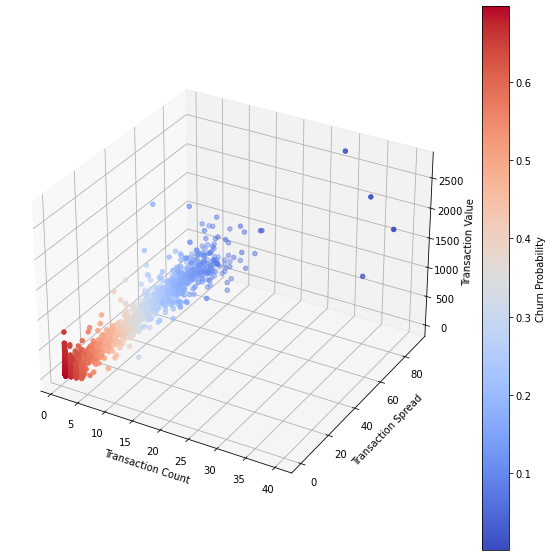

In [52]:
# 3D churn probability chart
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
transaction_count = df_user_dict['Transaction Count']
transaction_spread = df_user_dict['Transaction Spread']
transaction_value = df_user_dict['Transaction Value']
churn_probability = df_user_dict['Churn Probability']
scatter = ax.scatter(transaction_count, transaction_spread, transaction_value, c=churn_probability, cmap='coolwarm')
plt.colorbar(scatter, label='Churn Probability')
ax.set_xlabel('Transaction Count')
ax.set_ylabel('Transaction Spread')
ax.set_zlabel('Transaction Value')
plt.show()

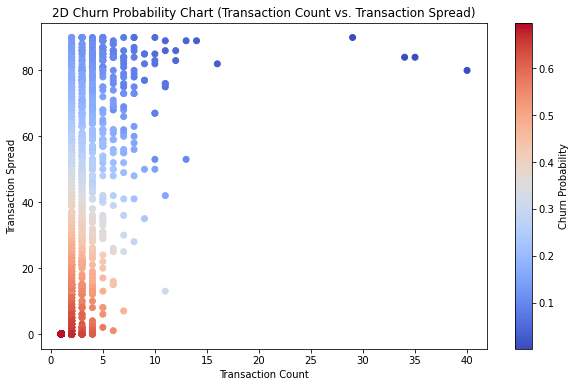

In [56]:
# 2D churn probability chart (key features)
plt.figure(figsize=(10, 6))
scatter = plt.scatter(transaction_count, transaction_spread, c=churn_probability, cmap='coolwarm')
plt.colorbar(scatter, label='Churn Probability')
plt.xlabel('Transaction Count')
plt.ylabel('Transaction Spread')
plt.title('2D Churn Probability Chart (Transaction Count vs. Transaction Spread)')
plt.show()

If were to make an advice on what might work for the product, I'd tell that encouraging user to making 5 transactions within 21 days or making 3 transactions within one month reduces changes of churn.